# Import Libraries

In [ ]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.3 MB/s eta 0:00:00


In [ ]:
!pip install colorama

In [ ]:
import os
import gc
import copy
import time
import pandas as pd
import numpy as np
import glob
import random
from tqdm import tqdm
from collections import defaultdict
from IPython import display as ipd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# Config

In [ ]:
class CFG:
    seed                   = 42
    exp_name               = 'VGG16'
    comment                = 'unet-vgg16-224x224-split2'
    model_name             = 'Unet'
    backbone               = 'vgg16'
    decoder_attention_type = 'scse'
    train_bs               = 16
    valid_bs               = 200
    test_bs                = 10
    img_size               = [224, 224]
    epochs                 = 50
    lr                     = 1e-4
    scheduler              = 'CosineAnnealingLR'
    min_lr                 = 1e-6
    T_max                  = 10
    T_0                    = 15
    warmup_epochs          = 5
    wd                     = 1e-5
    n_accumulate           = max(1, 32//train_bs)
    n_fold                 = 5
    num_classes            = 1
    thr                    = 0.45
    device                 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Seeding

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')

set_seed(CFG.seed)

> SEEDING DONE


# Data preprocessing

In [ ]:
# Directory containing files
directory = '/content/drive/MyDrive/EBHI-SEG'

# Create a DataFrame containing file paths for images and masks
df = pd.DataFrame(columns=['image_files', 'mask_files'])
cancer_types = ['Normal', 'Polyp', 'Low-grade IN', 'Adenocarcinoma', 'High-grade IN', 'Serrated adenoma']
label2id = {'Normal': 0, 'Polyp':1, 'Low-grade IN':2, 'Adenocarcinoma':3, 'High-grade IN':4, 'Serrated adenoma':5}

for cancer_type in cancer_types:
    image_dir = os.path.join(directory, cancer_type, 'image')
    mask_dir = os.path.join(directory, cancer_type, 'label')

    # Check if the image and mask directories exist
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Directory not found for {cancer_type}. Skipping...")
        continue

    image_files = sorted(os.listdir(image_dir))

    for file in image_files:
        image_file = os.path.join(image_dir, file)
        mask_file = os.path.join(mask_dir, file.replace('.jpg', '_mask.jpg'))  # Assuming mask file name is derived from image file name

        # Check if mask file exists
        if os.path.isfile(mask_file):
            df = pd.concat([df, pd.DataFrame({'image_files': [image_file], 'mask_files': [mask_file]})], ignore_index=True)

# # Shuffle the DataFrame
# df = df.sample(frac=1).reset_index(drop=True)

# Print the length of the DataFrame
print("Total number of samples:", len(df))

Total number of samples: 2226


In [ ]:
def label_image(img_path):
    for cancer_type in cancer_types:
        if cancer_type in img_path:
            return cancer_type

df['label names'] = df['image_files'].copy().map(label_image)

In [ ]:
def label_image_num(img_path):
    for label, cancer_type in enumerate(cancer_types):
        if cancer_type in img_path:
            return label

df['label'] = df['image_files'].copy().map(label_image_num)

In [ ]:
df_train, test_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True, stratify=df['label names'])

# Creating Dataset Objects


In [ ]:
class WSI_Dataset(Dataset):
    def __init__(self, dataframe, train=True):
        self.data = dataframe
        self.train = train
        self.labels = self.data['label'].tolist()  # Store labels for easy access

        if train:
            self.image_transform = train_image_transforms()
            self.mask_transform = mask_transforms()
        else:
            self.image_transform = valid_transforms()
            self.mask_transform = mask_transforms()  # Keep the transforms ready even for validation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_files']
        image = Image.open(image_path).convert("RGB")
        label = row['label']

        # Check if the mask path exists and is not NaN
        mask = None
        if 'mask_files' in row and pd.notna(row['mask_files']):
            mask_path = row['mask_files']
            mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        # Apply the image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Apply the mask transformation if mask is loaded
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label

In [ ]:
def mask_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.), torch.tensor(0.)))  # Thresholding operation
    ])

def valid_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
    ])

In [ ]:
test_ds = WSI_Dataset(test_df, train=False)

# Creating Dataloaders

In [ ]:
test_dataloader = DataLoader(test_ds, batch_size=CFG.test_bs,
                          num_workers=4, shuffle=False, pin_memory=False)

In [ ]:
ex_images, ex_masks, ex_labels = next(iter(test_dataloader))

print(ex_images.size(), ex_masks.size(), ex_labels.size())

torch.Size([10, 3, 224, 224]) torch.Size([10, 1, 224, 224]) torch.Size([10])


# Model

In [ ]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        decoder_use_batchnorm=True,
        # decoder_attention_type=CFG.decoder_attention_type,
        activation=None,
#         aux_params=CFG.aux_params
    )
    model.to(CFG.device)
    return model

def load_model(path):
    """
    Loads the model weights from a .pth or .bin file.

    Args:
    path (str): The path to the .pth or .bin file containing the model weights.

    Returns:
    torch.nn.Module: The model with loaded weights.
    """
    model = build_model()  # Ensure that build_model() is defined elsewhere and returns the model architecture

    if path.endswith('.pth'):
        checkpoint = torch.load(path)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
    elif path.endswith('.bin'):
        model.load_state_dict(torch.load(path))
    else:
        raise ValueError(f"Unsupported file extension: {os.path.splitext(path)[-1]}")

    model.eval()  # Set the model to evaluation mode
    return model

# Inference

In [ ]:
@torch.no_grad()
def infer(model_paths, test_loader, thr=CFG.thr, batch_size=CFG.test_bs):

    msks = np.zeros((len(test_loader)*batch_size, CFG.img_size[0], CFG.img_size[1], CFG.num_classes), dtype=float) # (n, h, w, c)
    gt_msks = np.zeros((len(test_loader)*batch_size, CFG.img_size[0], CFG.img_size[1], CFG.num_classes), dtype=float)
    imgs = np.zeros((len(test_loader)*batch_size, CFG.img_size[0], CFG.img_size[1], 3), dtype=float) # RGB
    labels = np.zeros(len(test_loader)*batch_size)  # To store the labels
    sample_counter = 0

    for idx, (img, gt_msk, label) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer')):  # Assuming test_loader returns (img, gt_msk, label)
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        gt_msk = gt_msk.to(CFG.device, dtype=torch.float)
        size = img.size()

        for path in model_paths:
            model = load_model(path)
            out = model(img) # .squeeze(0) # removing batch axis
            msk = nn.Sigmoid()(out) # removing channel axis

        msk = (msk.permute((0, 2, 3, 1)) > thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        img = img.permute((0, 2, 3, 1)).cpu().detach().numpy()
        gt_msk = gt_msk.permute((0, 2, 3, 1)).cpu().detach().numpy()
        label = label.cpu().detach().numpy()

        for i, gm, m, l in zip(img, gt_msk, msk, label):  # Add label to the loop
            imgs[sample_counter] = i
            msks[sample_counter] = m
            gt_msks[sample_counter] = gm
            labels[sample_counter] = l # Append the label
            sample_counter += 1

        del img, msk, out, model
        gc.collect()
        torch.cuda.empty_cache()

    return imgs, msks, gt_msks, labels  # Return labels as well


In [ ]:
model_paths = ['/content/drive/MyDrive/Models/unet-vgg16-baslinev2.bin']
images, masks, gt_masks, labels = infer(model_paths, test_dataloader)

Infer: 100%|██████████| 34/34 [02:08<00:00,  3.77s/it]


In [ ]:
print(images.shape, masks.shape, gt_masks.shape, labels.shape)

(340, 224, 224, 3) (340, 224, 224, 1) (340, 224, 224, 1) (340,)


# Evaluation Metrics

In [ ]:
def dice_coef(y_true, y_pred, thr=0.5, epsilon=0.001):
    """
    Calculates the Dice coefficient for binary mask arrays.

    Args:
    y_true (numpy.ndarray): Ground truth binary mask.
    y_pred (numpy.ndarray): Predicted binary mask.
    thr (float): Threshold to convert predicted probabilities into binary mask.
    epsilon (float): Small constant to avoid division by zero.

    Returns:
    float: Dice coefficient.
    """
    y_pred = (y_pred > thr).astype(np.float32)  # Apply threshold to prediction
    y_true = y_true.astype(np.float32)  # Ensure ground truth is float

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

In [ ]:
# Calculate the evaluation metrics

def calculate_segmentation_metrics(predicted_mask, ground_truth_mask):
    true_positive = np.logical_and(predicted_mask, ground_truth_mask).sum()
    false_positive = np.logical_and(predicted_mask, np.logical_not(ground_truth_mask)).sum()
    true_negative = np.logical_and(np.logical_not(predicted_mask), np.logical_not(ground_truth_mask)).sum()
    false_negative = np.logical_and(np.logical_not(predicted_mask), ground_truth_mask).sum()

    # Check for empty masks to avoid division by zero
    if (true_positive + false_positive + false_negative) == 0:
        return 0, 0, 0, 0, (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) if (true_positive + true_negative + false_positive + false_negative) > 0 else 0

    # Avoid division by zero
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    jaccard_similarity = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) > 0 else 0
    dice_score = (2 * true_positive) / (2 * true_positive + false_positive + false_negative) if (2 * true_positive + false_positive + false_negative) > 0 else 0
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) if (true_positive + true_negative + false_positive + false_negative) > 0 else 0

    return precision, recall, jaccard_similarity, dice_score, accuracy

In [ ]:
def evaluate_model_on_test_set(predicted_masks, ground_truth_masks, labels, label2id):

    num_classes = len(label2id)
    overall_metrics = {
        'precision': [],
        'recall': [],
        'jaccard_similarity': [],
        'dice_score': [],
        'accuracy': []
    }

    class_metrics = {
        label: {
            'precision': [],
            'recall': [],
            'jaccard_similarity': [],
            'dice_score': [],
            'accuracy': []
        } for label in label2id.keys()
    }

    for i in range(len(predicted_masks)):
        metrics = calculate_segmentation_metrics(predicted_masks[i], ground_truth_masks[i])
        for key, value in zip(overall_metrics.keys(), metrics):
            overall_metrics[key].append(value)

        # Calculate metrics per class
        class_label = list(label2id.keys())[labels[i]]
        for key, value in zip(class_metrics[class_label].keys(), metrics):
            class_metrics[class_label][key].append(value)

    # Calculate the average for overall metrics
    avg_overall_metrics = {key: np.mean(values) for key, values in overall_metrics.items()}

    # Calculate the average for each class
    avg_class_metrics = {
        label: {key: np.mean(values) for key, values in class_metrics[label].items()}
        for label in label2id.keys()
    }

    return avg_overall_metrics, avg_class_metrics


# Utility functions for visualization

In [ ]:
def select_random_samples(images, masks, gt_masks, labels, num_samples=10, seed=None):
    """
    Selects a random subset of images, masks, and ground truth masks.

    Args:
    images (numpy.ndarray): Array of images.
    masks (numpy.ndarray): Array of masks corresponding to the images.
    gt_masks (numpy.ndarray): Array of ground truth masks corresponding to the images.
    labels (numpy.ndarray): Array of labels corresponding to the images.
    num_samples (int): Number of random samples to select.
    seed (int or None): Random seed for reproducibility. Default is None.

    Returns:
    tuple: Arrays containing the selected images, masks, gt_masks, and labels.
    """
    # Check if the requested number of samples exceeds the number of available samples
    num_available = images.shape[0]
    if num_samples > num_available:
        raise ValueError("Requested number of samples exceeds the available samples.")

    # Set the random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Generate random indices
    indices = np.random.choice(num_available, size=num_samples, replace=False)

    # Select the samples using the generated indices
    selected_images = images[indices]
    selected_masks = masks[indices]
    selected_gt_masks = gt_masks[indices]
    selected_labels = labels[indices]

    return selected_images, selected_masks, selected_gt_masks, selected_labels


In [ ]:
def denormalize(image, mean, std):
    """
    Denormalizes an image with the given mean and std.

    Args:
    image (numpy.ndarray): The normalized image.
    mean (list): The mean used for normalization for each channel.
    std (list): The standard deviation used for normalization for each channel.

    Returns:
    numpy.ndarray: The denormalized image.
    """
    image = image * std + mean  # Apply denormalization
    image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1
    return (image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8


def overlay_mask(image, mask, mask_color=(255, 0, 0), alpha=0.5):
    """
    Overlay a mask onto an image.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): The binary mask (0s and 1s) to overlay.
    mask_color (tuple): The color to apply for the mask. Default is red (255, 0, 0).
    alpha (float): The transparency level of the mask overlay. Default is 0.5.

    Returns:
    numpy.ndarray: The image with the mask overlay.
    """

    # Check if the inputs are tensors and convert to numpy arrays if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Ensure the mask is 2D and matches the image dimensions
    if mask.ndim > 2:
        mask = mask.squeeze()  # Remove singleton dimensions

    # Create an RGB version of the mask
    colored_mask = np.zeros_like(image)
    for i in range(3):  # Apply the color to the mask
        colored_mask[..., i] = mask * mask_color[i]

    # Overlay the mask
    overlay_image = np.where(mask[..., None], (1 - alpha) * image + alpha * colored_mask, image).astype(np.uint8)

    return overlay_image



def display_comparison_grid(images, pred_masks, gt_masks, labels, label2id, mean, std, mask_colors=((0, 0, 255), (0, 255, 0)), alpha=0.5, grid_size=(10, 2)):
    """
    Displays a grid of images with predicted and ground truth masks overlayed for comparison.

    Args:
    images (list of numpy.ndarray): List of normalized images.
    pred_masks (list of numpy.ndarray): Corresponding list of predicted binary masks (0s and 1s).
    gt_masks (list of numpy.ndarray): Corresponding list of ground truth binary masks (0s and 1s).
    labels (list of int): Corresponding list of labels for the images.
    label2id (dict): Dictionary mapping label names to label indices.
    mean (list): The mean used for normalization.
    std (list): The standard deviation used for normalization.
    mask_colors (tuple of tuples): Colors to apply for the predicted and ground truth masks. Default is red for predictions and green for ground truth.
    alpha (float): The transparency level of the mask overlay. Default is 0.5.
    grid_size (tuple): Dimensions of the grid (rows, columns) for displaying the images. Each image will be displayed twice side by side with different masks.

    Returns:
    None: Displays the grid of overlayed images.
    """

    # Calculate how many images to display (considering each image is shown twice)
    num_images = min(len(images), grid_size[0] * grid_size[1] // 2)

    # Create figure with subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 3, grid_size[0] * 3))
    axes = axes.flatten()  # Flatten the grid to make indexing easier

    # Invert the label2id dictionary to get id2label
    id2label = {v: k for k, v in label2id.items()}

    # Loop over the number of images to display
    for idx in range(num_images):
        # Denormalize the image
        denorm_image = denormalize(images[idx], mean, std)

        # Calculate dice score
        dice_score = dice_coef(gt_masks[idx], pred_masks[idx])

        # Overlay predicted mask on image
        pred_overlay_image = overlay_mask(denorm_image, pred_masks[idx], mask_colors[0], alpha)
        # Overlay ground truth mask on image
        gt_overlay_image = overlay_mask(denorm_image, gt_masks[idx], mask_colors[1], alpha)

        # Show the image with predicted mask
        axes[2 * idx].imshow(pred_overlay_image)
        axes[2 * idx].axis('off')
        axes[2 * idx].set_title(f'Pred Mask\nDice: {dice_score:.2f}\nLabel: {id2label[labels[idx]]}')

        # Show the image with ground truth mask
        axes[2 * idx + 1].imshow(gt_overlay_image)
        axes[2 * idx + 1].axis('off')
        axes[2 * idx + 1].set_title(f'Ground Truth Mask\nLabel: {id2label[labels[idx]]}')

    # Clear any extra subplots if not all are used
    for idx in range(2 * num_images, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_class(images, pred_masks, gt_masks, labels, label2id, class_name, mean, std, num_samples=10):
    """
    Visualizes a specified number of images for a particular class.

    Args:
    images (list of numpy.ndarray): List of normalized images.
    pred_masks (list of numpy.ndarray): Corresponding list of predicted binary masks (0s and 1s).
    gt_masks (list of numpy.ndarray): Corresponding list of ground truth binary masks (0s and 1s).
    labels (list of int): Corresponding list of labels for the images.
    label2id (dict): Dictionary mapping label names to label indices.
    class_name (str): The name of the class to visualize.
    mean (list): The mean used for normalization.
    std (list): The standard deviation used for normalization.
    num_samples (int): Number of samples to visualize.

    Returns:
    None: Displays the images.
    """

    class_id = label2id[class_name]
    class_indices = [i for i, label in enumerate(labels) if label == class_id]

    if len(class_indices) == 0:
        print(f"No images found for class: {class_name}")
        return

    selected_indices = np.random.choice(class_indices, min(num_samples, len(class_indices)), replace=False)

    selected_images = [images[i] for i in selected_indices]
    selected_pred_masks = [pred_masks[i] for i in selected_indices]
    selected_gt_masks = [gt_masks[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]

    display_comparison_grid(selected_images, selected_pred_masks, selected_gt_masks, selected_labels, label2id, mean, std)

In [ ]:
def display_comparison_masks(images, pred_masks, gt_masks, labels, label2id, mean, std, grid_size=(10, 3)):
    """
    Displays a grid of images with their corresponding predicted and ground truth masks for comparison.

    Args:
    images (list of numpy.ndarray or torch.Tensor): List of normalized images.
    pred_masks (list of numpy.ndarray or torch.Tensor): Corresponding list of predicted masks.
    gt_masks (list of numpy.ndarray or torch.Tensor): Corresponding list of ground truth masks.
    labels (list of int): Corresponding list of labels for the images.
    label2id (dict): Dictionary mapping label names to label indices.
    mean (list): The mean used for normalization.
    std (list): The standard deviation used for normalization.
    grid_size (tuple): Dimensions of the grid (rows, columns) for displaying the images.

    Returns:
    None: Displays the grid of images and masks.
    """

    num_images = min(len(images), grid_size[0])

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 3, grid_size[0] * 3))
    axes = axes.flatten()  # Flatten the grid to make indexing easier

    id2label = {v: k for k, v in label2id.items()}

    for idx in range(num_images):
        denorm_image = denormalize(images[idx], mean, std)

        # Display the denormalized image
        ax = axes[idx * grid_size[1]]
        ax.imshow(denorm_image)
        ax.axis('off')
        ax.set_title(f'Image\nLabel: {id2label[labels[idx]]}')

        # Display the predicted mask
        ax = axes[idx * grid_size[1] + 1]
        pred_mask = pred_masks[idx].squeeze()  # Ensure it's 2D
        ax.imshow(pred_mask, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{CFG.model_name}|{CFG.exp_name}')

        # Display the ground truth mask
        ax = axes[idx * grid_size[1] + 2]
        gt_mask = gt_masks[idx].squeeze()  # Ensure it's 2D
        ax.imshow(gt_mask, cmap='gray')
        ax.axis('off')
        ax.set_title('Ground Truth Mask')

    for idx in range(num_images * grid_size[1], len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


# Result

In [ ]:
avg_overall_metrics, avg_class_metrics = evaluate_model_on_test_set(masks, gt_masks, label_list, label2id)

print("Average metrics over the whole test set:")
for key, value in avg_overall_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage metrics per class:")
for label, metrics in avg_class_metrics.items():
    print(f"\nClass: {label}")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}")

# Sample Visualizations

In [ ]:
mean = [0.519624, 0.34783007, 0.68143765]
std = [0.22924705, 0.24072345, 0.14470555]

selected_images, selected_masks, selected_gt_masks, selected_labels = select_random_samples(images, masks, gt_masks, labels, num_samples=10, seed=43)
display_comparison_grid(selected_images, selected_masks, selected_gt_masks, selected_labels, label2id, mean, std)

Output hidden; open in https://colab.research.google.com to view.

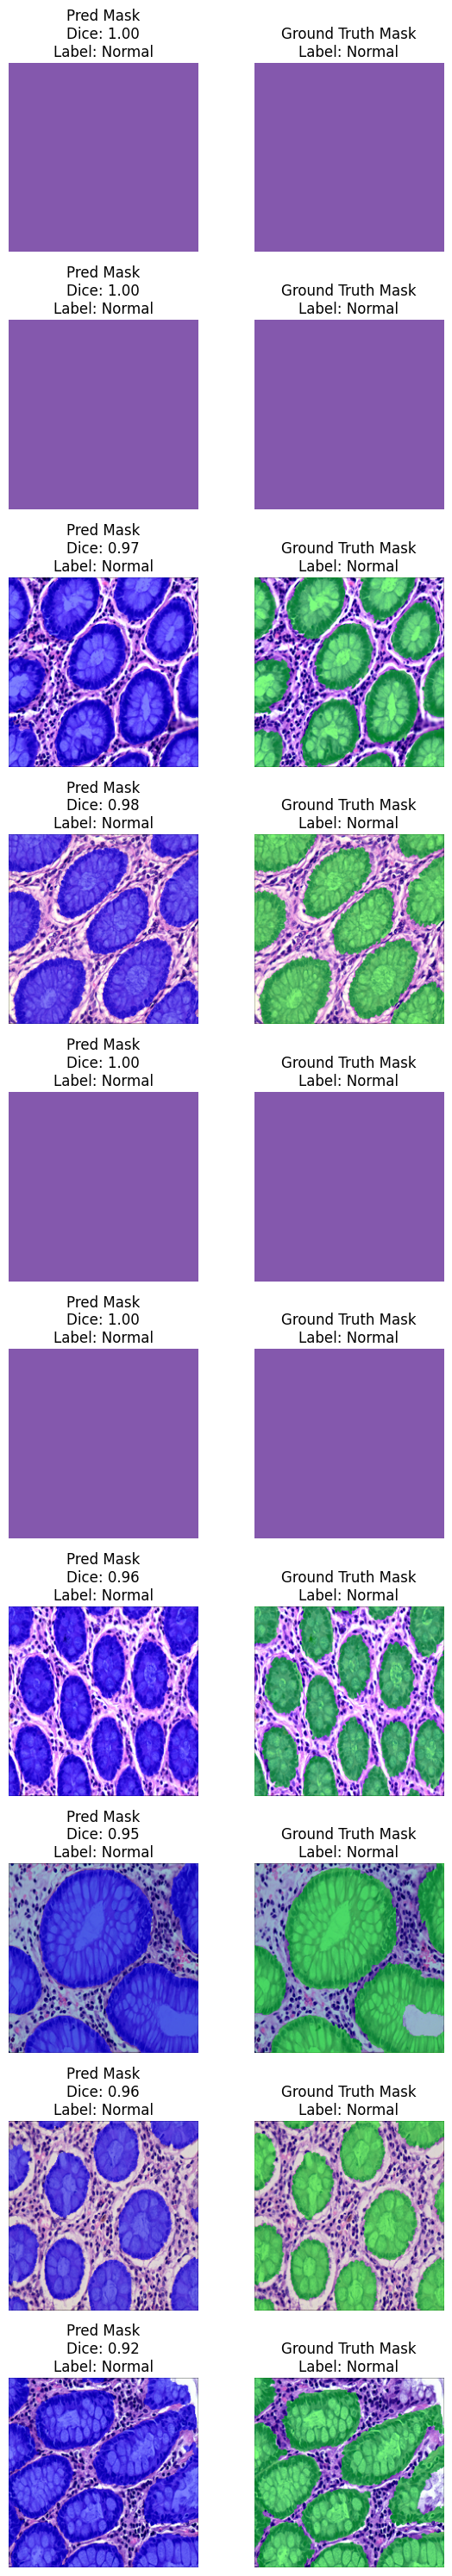

In [ ]:
# Visualize images for different cancer types
visualize_class(images, masks, gt_masks, labels, label2id, 'Normal', mean, std, num_samples=10)

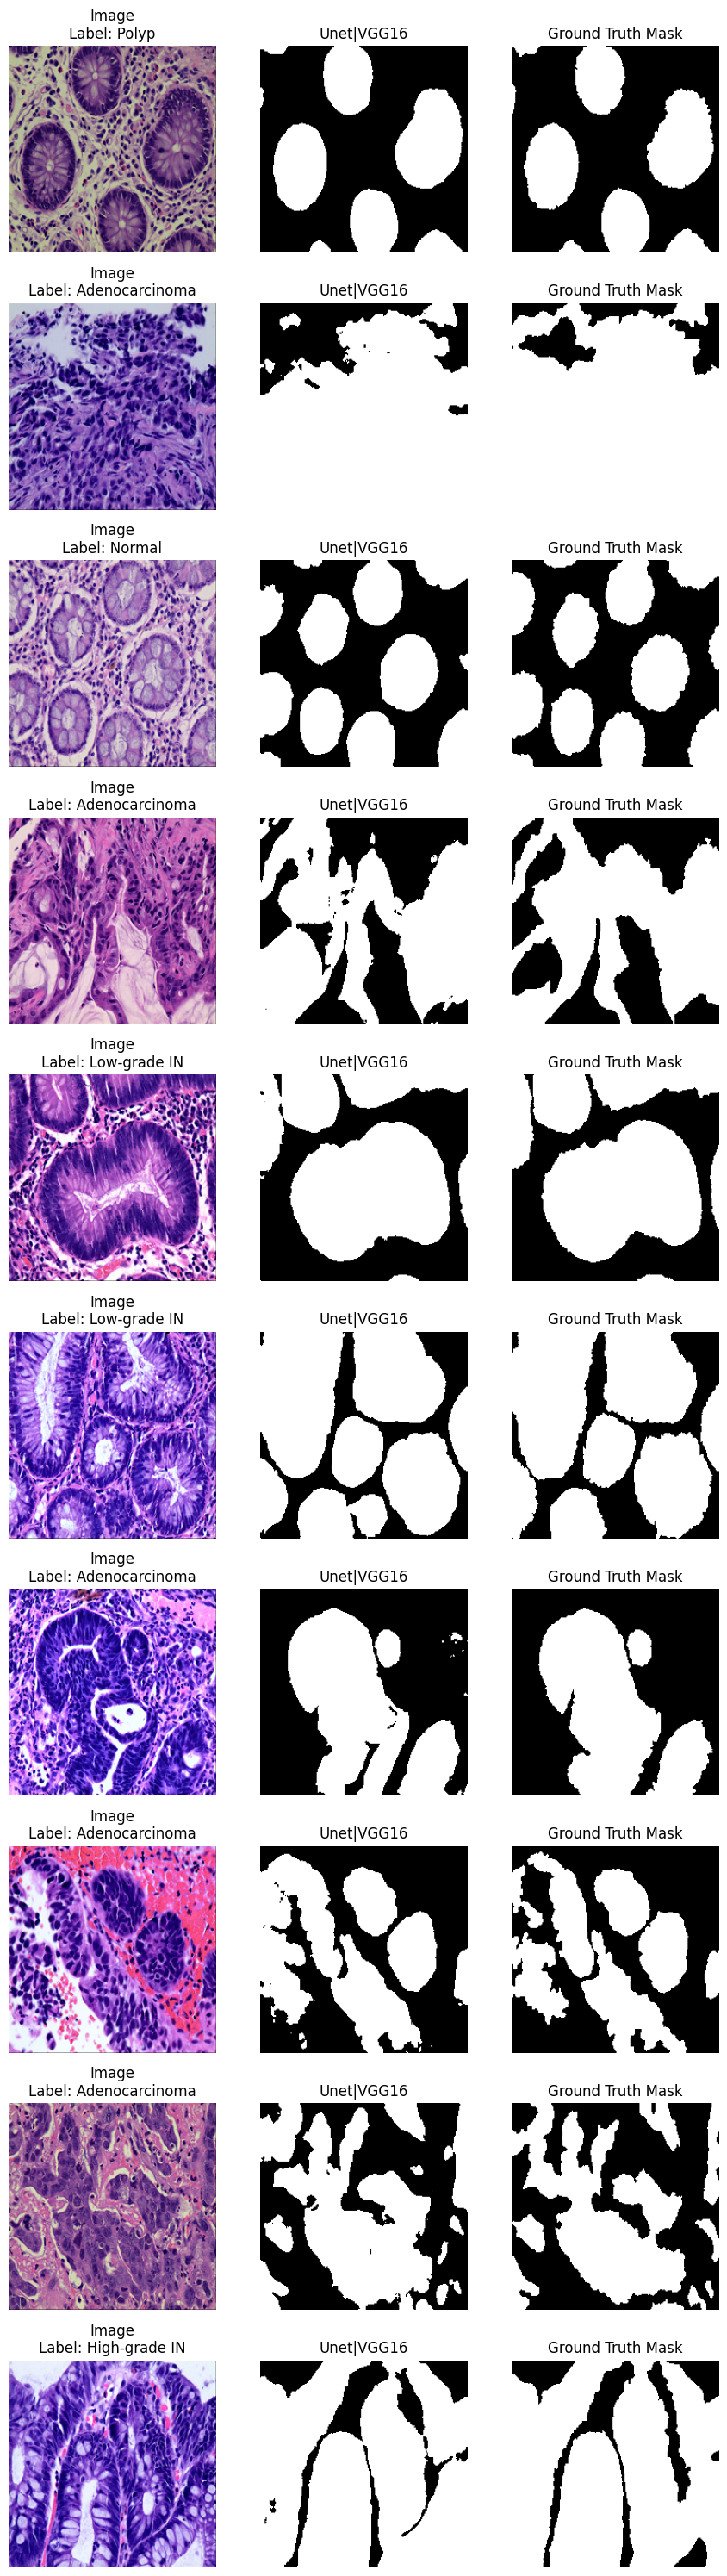

In [ ]:
display_comparison_masks(selected_images, selected_masks, selected_gt_masks, selected_labels, label2id, mean, std)